<h2><font color="#004D7F" size=6>Módulo 8. Aprendizaje No Supervisado</font></h2>



<h1><font color="#004D7F" size=5>8.2.2. Ejercicio práctico con PCA</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Machine Learning con Python</font><br>

<br>

---

---
<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [1. Introducción](#section1)
* [2. PCA para la identificación de caras: _eigenfaces_](#section2)
    * [2.1. Creación de conjuntos de entrenamiento y test](#section21)
    * [2.2. Aprendizaje de un modelo](#section22)
    * [2.3. Entrenamiento de un modelo a partir de características creadas con PCA](#section23)
    * [2.4. Estudio de las componentes](#section24)
* [3. PCA como técnica de filtrado de ruido](#section3)
* [4. Práctica](#section4)


<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción </font>
<br>

En esta libreta se proponen dos ejercicios que ilustran parte de la utilidad de PCA. El primero de ellos muestra como el uso de características construídas con PCA permite mejorar los resultados de un algoritmo de clasificación. El segundo, cómo PCA puede ser utilizada para. la eliminación de ruido.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


#Esta celda de código permite reducir el tamaño de los márgenes laterales  y aprovechar mejor el tamaño de la ventana.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section2"></a>
# <font color="#004D7F"> 2. PCA para la identificación de caras: _eigenfaces_ </font>
<br>

_Eigenfaces_ es un algoritmo para el reconocimiento/clasificación de caras a través de clasificación supervisada. Se llama así porque se una de las claves de su funcionamiento consiste en el uso de PCA para la extracción de componentes principales (_eigenvectors_ y _eigenvalues_).


__Nota__: Esta a aplicación es una de las más extendidas para ilustrar el funcionamiento de PCA, y existen numerosas versiones en la red. 

---

 La librería `scikit-learn` contiene algunos datasets, con formatos característicos, destinados a pruebas. Uno de ellos es [`lfw_people`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html), que contiene datos sobre fotografías etiquetadas de 7 personas. Originalmente, cada fotografía se representa con 256 niveles de gris, y está compuesta de $125\times94$ puntos. Es decir, cada fotografía se puede representar como una tupla de $125\times94=11750$ variables numéricas.  Sin embargo, la función permite descargar versiones reducidas (lo que disminuye también la dimensionalidad del problema).
 
En la siguiente celda, se va a descargar una versión del conjunto de datos original que incluye un mínimo de 70 caras por cada persona, y que se ha escalado al %40 del tamaño.

__Nota__: Por defecto, estos datos se guardan en una carpeta. Por ejemplo, en _MacOs_ se guardan en `~/scikit_learn_data/lfw_home`, pero en un formato propio.

In [2]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

La estructura `lfw_people.images` contiene cada imagen en formato matriz. De ella se pueden obtener las dimensiones de cada imagen. 

In [3]:
_ , height, width = lfw_people.images.shape
print("Altura de cada imagen: ", height)
print("Anchura de cada imagen: ", width)

Altura de cada imagen:  50
Anchura de cada imagen:  37


La estructura `lfw_people.data` es una matriz bidimensional en la que cada imagen se representa como una tupla, y será la utilizada en el proceso de aprendizaje. 

In [4]:
n_samples, n_features = lfw_people.data.shape
print("Número de caras: ", n_samples)
print("Número de características: ", n_features)

Número de caras:  1288
Número de características:  1850


Con respecto a las clases, existen dos estructuras de datos. La primera de ellas, `lfw_people.target`, contiene la etiqueta (numérica) de cada entrada. La segunda, `lfw_people.target_names` contiene el nombre correspondiente a cada etiqueta. 

In [5]:
n_classes = len(np.unique(lfw_people.target))
print("Número de clases: ", n_classes)
print()

target_names = lfw_people.target_names
for i,name in enumerate(target_names):
    print(i,name)

Número de clases:  7

0 Ariel Sharon
1 Colin Powell
2 Donald Rumsfeld
3 George W Bush
4 Gerhard Schroeder
5 Hugo Chavez
6 Tony Blair


La siguiente celda muestra la primera cara de la base de datos. 

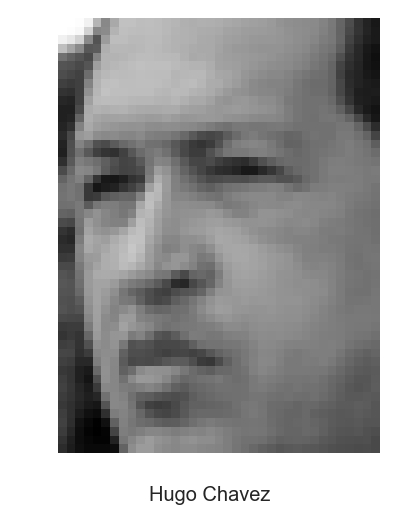

In [6]:
#plt.imshow(lfw_people.data[0].reshape((height, width)), cmap=plt.cm.gray) # Ambas formas con equivalentes
plt.imshow(lfw_people.images[0], cmap=plt.cm.gray)
plt.text(10,55, lfw_people.target_names[lfw_people.target[0]])
plt.axis("off");

En primer lugar, se va a inspeccionar la distribución de las clases. 

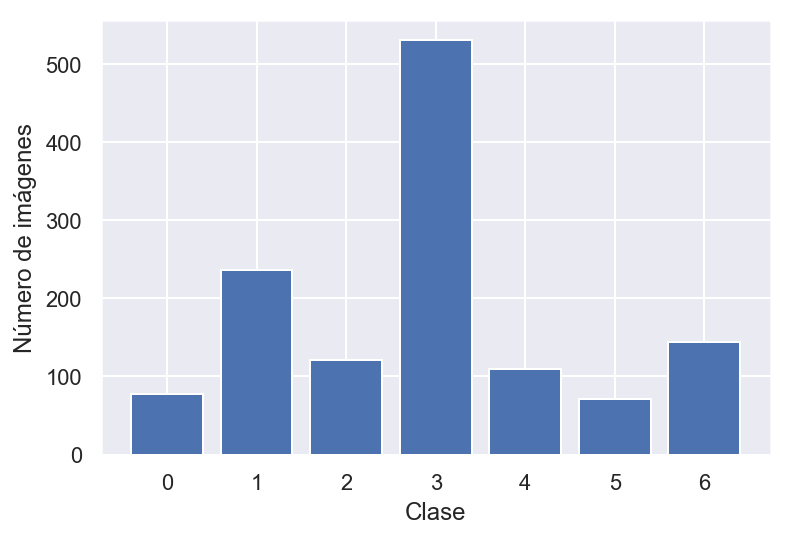

In [7]:
classes, counts = np.unique(lfw_people.target, return_counts=True)
plt.bar(classes, counts)
plt.xlabel('Clase')
plt.ylabel('Número de imágenes');

Puede observarse que casi la mitad de las entradas corresponden a la segunda clase, _George Bush_. Esto puede degradar el funcionamiento del clasificador. No obstante, en situaciones reales, se ha de asumir que ese _desbalanceo_ se presentará en los nuevos datos, por lo que puede ser conveniente no modificar la distribución de las clases en los datos de entrenamiento.

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section21"></a>
## <font color="#004D7F"> 2.1. Creación de conjuntos de entrenamiento y test </font>
<br>

En primer lugar, se han de crear los conjuntos de entrenamiento y test.

<div class="alert alert-block alert-info">
    
<font size=4> <i class="fa fa-book" aria-hidden="true" style="color:#004D7F"></i> </font> __Nota muy importante__: El conjunto de test se utiliza solamente para reportar los datos del modelo final. Es decir, para ajustar parámetros se ha de utilizar validación cruzada sobre el conjunto de entrenamiento, o volver a dividir el conjunto de entrenamiento en entrenamiento/validación.
</div>


In [8]:
from sklearn.model_selection import train_test_split

X = lfw_people.data
y = lfw_people.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section22"></a>

## <font color="#004D7F"> 2.2. Aprendizaje de un modelo </font>
<br>

Con el fin de comparar, se va a aprender, en primer lugar, un modelo SVC (_máquina de soporte vectorial_). Debido a que este algoritmo es sensible a algunos parámetros, se va a llevar a cabo una búsqueda de los dos más principales: `C` que cuantifica la penalización (es parecido a la regularización), y `gamma`, que permite determinar el radio del kernel `rbf` utilizado. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Tarda aproximadamente 10 minutos (en el equipo en el que se ha elaborado esta libreta). 
</div>

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from time import time

In [10]:
#param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
#
#t0 = time()
#clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)
#
#clf = clf.fit(X_train, y_train)
#print("Tiempo:  %0.3fs" % (time() - t0))

#print("Mejor clasificador: ")
#print(clf.best_estimator_)

In [11]:
import pickle


clf = pickle.load(open("clf.p", "rb" ))

La siguiente celda muestra la tasa de acierto del clasificador.

In [12]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
print("La tasa de acierto del clasificador es: ",accuracy_score(y_test, y_pred))

La tasa de acierto del clasificador es:  0.453416149068323


Puede observarse que la tasa de acierto es muy baja.  La matriz de confusión permite obtener información más detallada del rendimiento del algoritmo. 

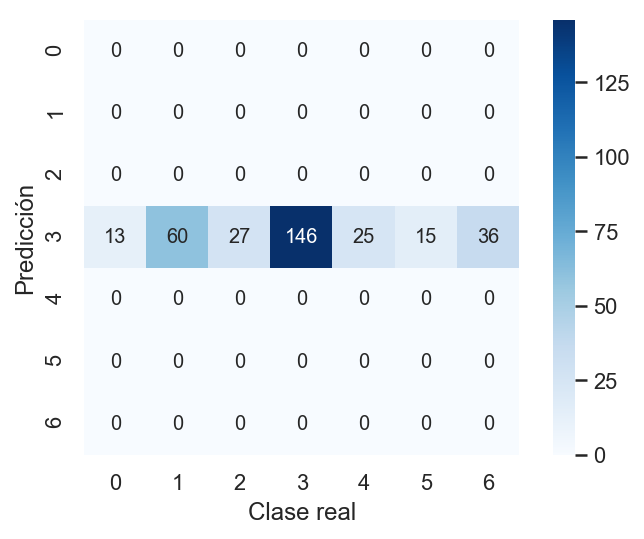

In [13]:
from sklearn.metrics import confusion_matrix

c_mat = confusion_matrix(y_test, y_pred, labels=range(n_classes))

sns.heatmap(c_mat.T, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
plt.xlabel('Clase real')
plt.ylabel('Predicción');

Anteriormente se observó que hay una clase mayoritaria (la 2). El clasificador predice esta clase para todos los casos. Esto indica que no es capaz de discriminar entre una y otra clase.

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section23"></a>
## <font color="#004D7F"> 2.3. Entrenamiento de un modelo a partir de características creadas con PCA </font>
<br>

Los resultados obtenidos con el clasificador anterior son pobres. Esto se debe, a que la relación de un píxel por sí solo con la etiqueta es prácticamente nula. A continuación, se van a extraer las 150 componentes principales, y se van a utilizar los datos proyectados a partir de éstas como datos de entrenamiento.

En primer lugar, se obtienen las componentes. Existe un parámetro, `whithen`, muy importante para este uso del PCA. Básicamente, consiste en scalar la proyección de los datos para que la varianza de cada característica sea uno.

In [14]:
from sklearn.decomposition import PCA
n_components = 150

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

Una vez obtenidas las componentes, se creará un conjunto de entrenamiento alternativo con la proyección de los datos. Este se almacenará en la variable `X_train_pca`, y tiene el mismo número de filas, y 150 columnas (tantas como componentes).

In [15]:
X_train_pca = pca.transform(X_train)
print('Tamaño del conjunto original: ', X_train.shape)
print('Tamaño del conjunto projectado: ', X_train_pca.shape)

Tamaño del conjunto original:  (966, 1850)
Tamaño del conjunto projectado:  (966, 150)


A continuación se entrenará el modelo con los nuevos datos. 

In [16]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

t0 = time()
clf_pca = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)

clf_pca = clf_pca.fit(X_train_pca, y_train)
print("Tiempo:  %0.3fs" % (time() - t0))

print("Mejor clasificador: ")
print(clf_pca.best_estimator_)

/Users/luisdelaossa/Library/venvs/ds/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tiempo:  43.927s
Mejor clasificador: 
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Puede observarse que el entrenamiento del modelo es sustancialmente más rápido (52 segundos en el equipo en el que se ha elaborado esta libreta).
<br>


A continuación se evaluará el modelo. La siguiente celda produciría error:

In [17]:
#y_pred = clf_pca.predict(X_test)

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
El modelo `clf` se ha aprendido a partir de una base de datos con 150 características, correspondientes a las componentes. Es decir, para evaluar el modelo sobre datos de test, se han de preprocesar estos datos del mismo modo.
</div>


In [18]:
X_test_pca = pca.transform(X_test)

Ahora sí que se puede obtener la tasa de acierto.

In [19]:
y_pred = clf_pca.predict(X_test_pca)
print("La tasa de acierto del clasificador es: ",accuracy_score(y_test, y_pred))

La tasa de acierto del clasificador es:  0.8509316770186336


Se ha incrementado la tasa de acierto a un nivel aceptable. Esto se refleja también en la matriz de confusión.

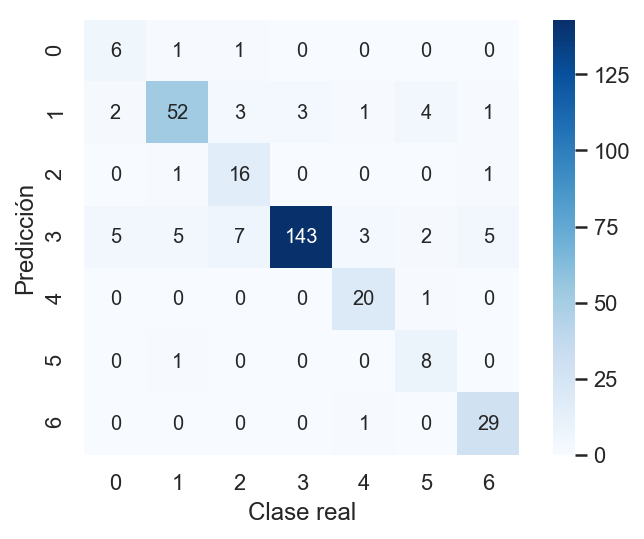

In [20]:
c_mat = confusion_matrix(y_test, y_pred, labels=range(n_classes))

sns.heatmap(c_mat.T, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
plt.xlabel('Clase real')
plt.ylabel('Predicción');

Puede apreciarse que la diagonal contiene los valores más algos. También que se predice la clase 3 a algunas imágenes que no lo son. La función `classification_report` de `scikit-learn` permite obtener información más detallada.

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.89      0.59      0.71        27
    George W Bush       0.84      0.98      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.97      0.81      0.88        36

        micro avg       0.85      0.85      0.85       322
        macro avg       0.87      0.72      0.78       322
     weighted avg       0.86      0.85      0.84       322



Además de los valores correspondientes a cada clase, puede observarse que la función reporta la _macro media_ y la _micro media_. La _macro media_ es la media de los valores individuales para cada clase.  La _micro media_ calcula las medidas a partir de la matriz de precisión. 

Puede observarse que los mejores resultados se obtienen para George W Bush. Esto guarda relación con el hecho de que aparezca más veces en la base de datos.

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section24"></a>

## <font color="#004D7F"> 2.4. Estudio de las componentes </font>
<br>

La siguiente figura muestra gráficamente el contenido de las diez primeras componentes. 

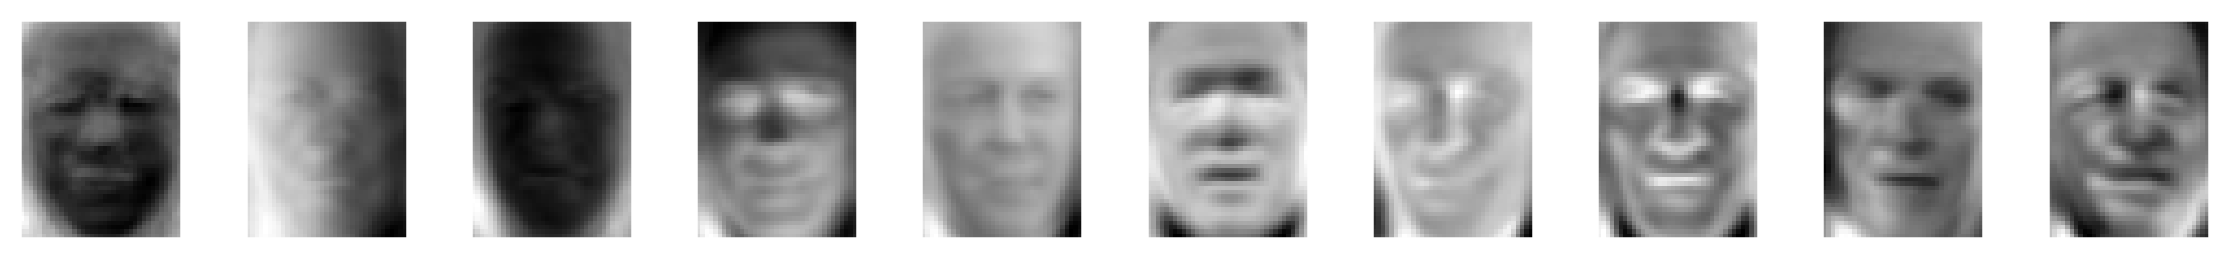

In [22]:
def plot_images(images, shape, grid):
    fig, axes = plt.subplots(grid[0], grid[1], figsize=(20,2),
                             subplot_kw={'xticks':[], 'yticks':[]},  
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    
    # Recorre cada objeto axes que contiene la figura
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i,:].reshape(shape), cmap=plt.cm.gray, interpolation='nearest')
        
plot_images(pca.components_[:10,:], shape=(height,width), grid=(1,10))   

Puede apreciarse que, visualmente, pueden apreciarse ciertas características. 

A continuación, se muestra como la cara mostrada en el ejemplo se reconstruye a partir de las componentes y sus proyeccciones.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Por claridad, vamos a utilizar el PCA con `whiten=False`, que es el que hemos estudiado.
</div>

In [23]:
pca_nw = PCA(150).fit(X)
X_pca_nw = pca_nw.transform(X)
# Escogemos una cara
x_pca_0 = X_pca_nw[0,:]


A continuación, se harán 150 reconstrucciones de esa cara. Para la reconstrucción $k$ se usan las $k$ primeras componentes principales.  

In [24]:
# Contiene 150 versiones de la misma cara. 
x_app_0 = np.zeros((150,n_features))
# Con la primera componente principal
x_app_0[0,:] = pca_nw.mean_ + x_pca_0[0]*pca_nw.components_[0,:]
# Añade cada reconstrucción
for k in range(1,150):
    x_app_0[k,:] = x_pca_0[k]*pca_nw.components_[k,:] + x_app_0[k-1,:]         # Son equivalentes
    #x_app_0[k,:] = np.dot(x_pca_0[:k],pca_nw.components_[:k,:])+pca_nw.mean_

Muestra la reconstrucción

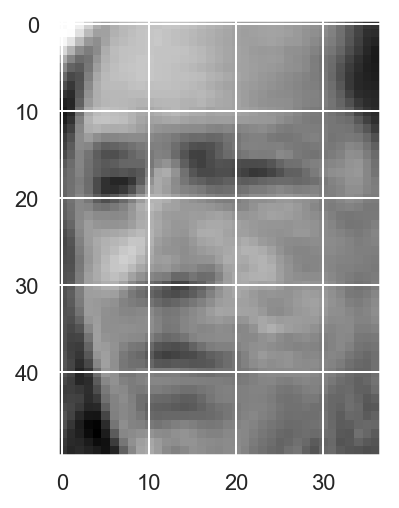

In [25]:
plt.imshow(x_app_0[-1,:].reshape(height,width), cmap=plt.cm.gray);

A continuación, se muestran las imágenes para algunos valores de $k$.

In [26]:
selectedK = np.linspace(1,160,16, endpoint=False).astype(int)-1

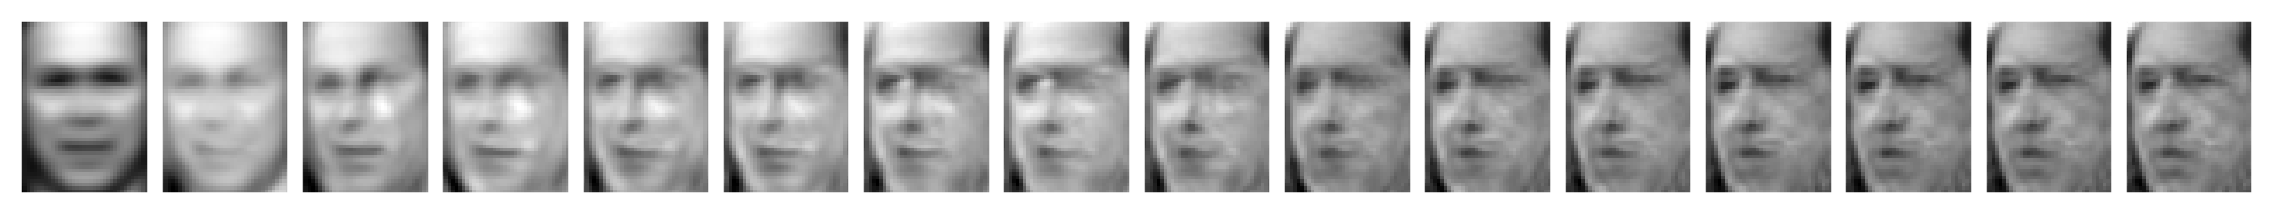

In [27]:
images = x_app_0[selectedK,:]
plot_images(images, shape=(height,width), grid=(1,16)) 

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section3"></a>
# <font color="#004D7F"> 3. PCA como técnica de filtrado de ruido </font>
<br>

PCA puede utilizarse también como método para filtrar ruido. Debido a que las componentes capturan la información importante, es de esperar que la información descartada corresponda a ruido.

La siguiente base de datos, contiene imágenes de dígitos escritos a mano. Cada una de ellas ocupa $8\times8$ píxeles, y están representadas con 255 niveles de gris. 

In [28]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [29]:
digits.target[:40]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9])

Esta función, similar a la anterior, introduce alguna modificación para que se muestren mejor los números.

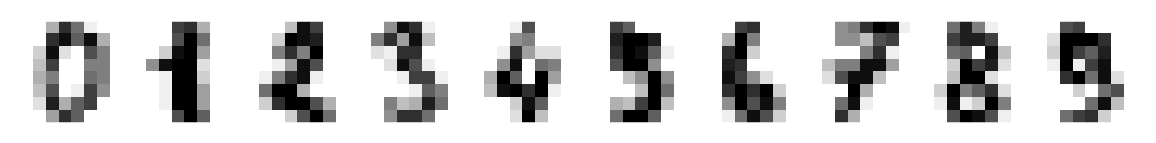

In [30]:
def plot_digits(images, shape, grid):
    fig, axes = plt.subplots(grid[0], grid[1], figsize=(10,10),
                             subplot_kw={'xticks':[], 'yticks':[]},  
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    
    # Recorre cada objeto axes que contiene la figura
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i,:].reshape(shape),  cmap='binary', interpolation='nearest', clim=(0, 16))

# Muestra las 10 primeras imágenes
plot_digits(digits.data[:10,:], shape=(8,8), grid=(1,10)) 

A continuacion, se crea otro conjunto de datos `noisy`, en el que se añade ruido a cada imagen. 

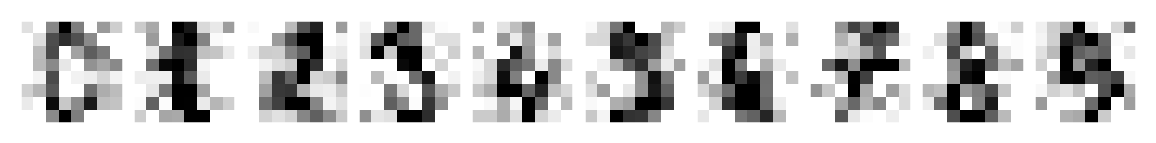

In [31]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy[:10,:], shape=(8,8), grid=(1,10)) 

Por último, se muestran las imágenes reconstruídas. Como puede apreciarse, gran parte del ruido se ha eliminado o reducido.

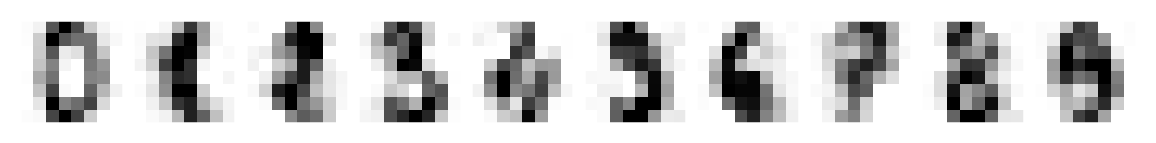

In [32]:
pca = PCA(0.5).fit(noisy)
pca.n_components_

components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered[:10,:], shape=(8,8), grid=(1,10)) 

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section4"></a>
# <font color="#004D7F"> 4. Práctica </font>
<br>

En esta clase se ha visto el algoritmo por excelencia para este tipo de trabajos como es PCA, aunque no es el único interesante que existe. En este sentido, para la práctica se pide utilizar dos diferentes algoritmos para esos mismos conjuntos de datos y discutir el rendimiento de entre ellos. Estos algoritmos serán:
1. TruncatedSVD - [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
    * Vemos como al igual que PCA también alcanza un porcentaje de acierto aceptable. La diferencia con PCA no prioriza la varianza explicada, sino que maximiza la 'separación' entre clases.
    * Fue necesario también normalizar los datos para obtener este acuracy.
    * TruncatedSVD es una alternativa a PCA cuando el input es muy disperso(no es el caso del ejemplo), pero en otros escenarios tsvd puede trabajar de manera más eficiente
    * "Notice that this class does not support sparse input. See TruncatedSVD for an alternative with sparse data." (documentación de PCA).
2. $t$-SNE - [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
2. Un algoritmo que podáis encontrar y que sea interesante

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>